___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2024

___
### Import libraries and sub-libraries.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from skimage.metrics import structural_similarity as ssim
import tifffile 

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [ ]:
from fontsetting import font_cmu
plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [ ]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

___
### Read training & validation data from `data/train-clean-tif` and `data/val-clean-tif`


In [24]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.1), (0.1))
])


# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)

# Create the dataset for the validation images
val_dataset = TIFFDataset('val-clean-tif', transform=transform)

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

train_dataset_size = len(train_dataset)
print('Number of images in the train dataset:', train_dataset_size)

val_dataset_size = len(val_dataset)
print('Number of images in the validation dataset:', val_dataset_size)

Number of images in the train dataset: 52
Number of images in the validation dataset: 16


___
### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [ ]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

#### MihirNet2

In [31]:
class MihirNet2(nn.Module):
  def __init__(self):
    super(MihirNet2, self).__init__()
    self.k1 = 3 # TODO: change kernel size
    self.dropout = 0.5
    self.conv1_skip = nn.Sequential(
      nn.Conv2d(1, 128, kernel_size=self.k1, padding=(1,1)),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU()) # size: 128x128
    
    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=self.k1, padding=(1,1)),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU(),
      nn.Dropout(0.1)) # size: 128x128
    
    self.conv1b = nn.Sequential(
      nn.Conv2d(16, 32, kernel_size=self.k1, padding=(1,1)),
      nn.ReLU())
    
    self.conv1c = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=self.k1, padding=(1,1)),
      nn.ReLU())
    
    self.conv1d = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=self.k1, padding=(1,1)),
      nn.ReLU())
    
    self.conv2 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=self.k1, padding=(1,1)),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU(),
      nn.Dropout(0.1))
    
    self.conv2_skip = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=self.k1, padding=(1,1)),
      nn.ReLU())
    
    self.conv3 = nn.Sequential(
      nn.Conv2d(128, 256, kernel_size=self.k1, padding=(1,1)),
      nn.ReLU(),
      nn.Dropout(0.25))
    
    self.conv4 = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=self.k1, padding=1),
      nn.ReLU(),
      nn.Dropout(0.25))
    
    self.conv4a = nn.Sequential(
      nn.Conv2d(512, 256, kernel_size=self.k1, padding=1),
      nn.ReLU())
    
    self.conv5a = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=self.k1, padding=1),
      nn.ReLU())
    
    self.conv5b = nn.Sequential(
      nn.Conv2d(64, 1, kernel_size=self.k1, padding=1),
      nn.ReLU())

    self.conv5c = nn.Sequential(
      nn.Conv2d(32, 1, kernel_size=self.k1, padding=1),
      nn.ReLU())
    
    
    
    self.up1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
    self.up2 = nn.ConvTranspose2d(in_channels=640, out_channels=128, kernel_size=2, stride=2)
    

  def forward(self, x):

    skip1 = self.conv1_skip(x)

    x = self.conv1(x)
    # print(f"conv1 size: {x.shape}")
    x = self.conv1b(x)
  
    # print(f"conv1b size: {x.shape}")
    x = self.conv1c(x)
    # print(f"conv1c size: {x.shape}")

    # x = self.conv1d(x)

    # skip2 = self.conv2_skip(x)
    # print(f"skip2 size: {x.shape}")

    x = self.conv2(x)
    # print(f"conv2 size: {x.shape}")


    x = self.conv3(x)
    # print(f"conv3 size: {x.shape}")
    # print(f"0: {x.shape}")

    x = self.up1(x)
    # print(f"upsam1 size: {x.shape}")

    # x = torch.cat((x, skip2))  # Concatenate along channel dimension
    # print(f"concat1 output: {x.shape}")
    x = self.conv4(x)
    # print(f"conv4 size: {x.shape}")
    # x = self.conv5(x)
    # print(f"2: {x.shape}")
    
    # print(f"3: {x.shape}")
    x = torch.cat((x, skip1))  # Concatenate along channel dimension
    # print(f"concat output: {x.shape}")
    x = self.up2(x)
    # print(f"upsamp2 size: {x.shape}")
    
    x = self.conv5a(x)
    x = self.conv5b(x)
    # x = self.conv5c(x)
    # print(f"4: {x.shape}")
    
    return x
  

  #TODO: 
  # - add more skip connections
  # - add batch norm
  # - add dropout
  # - change learning rate

### MihirNet3

In [66]:
class MihirNet3(nn.Module):
  def __init__(self):
    super(MihirNet3, self).__init__()
    self.k1 = 3 # TODO: change kernel size
    
    self.printOutput = False

    self.conv1_skip = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=self.k1, padding=(1,1)),
      # nn.BatchNorm1d(256),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU()) # size: 128x128
    
    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=self.k1, padding=(1,1)),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU(),
      nn.Dropout3d(0.1))
    
    
    # TODO: change activation to LeakyReLU
    self.conv1b = nn.Sequential(
      nn.Conv2d(16, 32, kernel_size=self.k1, padding=(1,1)),
      # nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU())
    
    self.conv1c = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=self.k1, padding=(1,1)),
      # nn.BatchNorm1d(64),
      # nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU())
    
    self.conv1d = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=self.k1, padding=(1,1)),
      # nn.BatchNorm1d(64),
      # nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU())
    
    self.conv2 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=self.k1, padding=(1,1)),
      # nn.BatchNorm1d(512),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
      nn.ReLU())
    
    self.conv2_skip = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=self.k1, padding=(1,1)),
      nn.Dropout(),
      nn.ReLU())
    
    self.conv3 = nn.Sequential(
      nn.Conv2d(128, 256, kernel_size=self.k1, padding=(1,1)),
      # nn.BatchNorm1d(512),
      nn.ReLU())
    
    self.conv4 = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=self.k1, padding=1),
      # nn.BatchNorm1d(256),
      nn.ReLU())
    
    self.conv4a = nn.Sequential(
      nn.Conv2d(512, 256, kernel_size=self.k1, padding=1),
      # nn.BatchNorm1d(256),
      nn.ReLU())
    
    self.conv5a = nn.Sequential(
      nn.Conv2d(256, 128, kernel_size=self.k1, padding=1),
      # nn.BatchNorm1d(256),
      nn.ReLU())
    
    self.conv5b = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=self.k1, padding=1),
      # nn.BatchNorm1d(256),
      nn.ReLU())

    self.conv5c = nn.Sequential(
      nn.Conv2d(64, 1, kernel_size=self.k1, padding=1),
      nn.ReLU())
    
    
    
    self.up1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
    self.up2 = nn.ConvTranspose2d(in_channels=192, out_channels=128, kernel_size=2, stride=2)
    

  def forward(self, x):

    skip1 = self.conv1_skip(x)
    if self.printOutput:
      print(f"skip1 size: {skip1.shape}")

    x = self.conv1(x)
    if self.printOutput:  
      print(f"conv1 size: {x.shape}")

    x = self.conv1b(x)
    if self.printOutput:
      print(f"conv1b size: {x.shape}")

    x = self.conv1c(x)
    if self.printOutput:
      print(f"conv1c size: {x.shape}")

    # x = self.conv1d(x)

    # skip2 = self.conv2_skip(x)
    # print(f"skip2 size: {x.shape}")

    x = self.conv2(x)
    if self.printOutput:
      print(f"conv2 size: {x.shape}")


    x = self.conv3(x)
    if self.printOutput:
      print(f"conv3 size: {x.shape}")
    # print(f"0: {x.shape}")

    x = self.up1(x)
    if self.printOutput:  
      print(f"upsam1 size: {x.shape}")

    # x = torch.cat((x, skip2))  # Concatenate along channel dimension
    # print(f"concat1 output: {x.shape}")
    x = self.conv4(x)
    if self.printOutput:
      print(f"conv4 size: {x.shape}")

    x = self.conv4a(x)
    if self.printOutput:
      print(f"conv4a size: {x.shape}")
    # x = self.conv5(x)
    # print(f"2: {x.shape}")
    
    # print(f"3: {x.shape}")
    
    # print(f"upsamp2 size: {x.shape}")
    
    x = self.conv5a(x)
    if self.printOutput:
      print(f"conv5a size: {x.shape}")

    x = torch.cat((x, skip1))  # Concatenate along channel dimension
    if self.printOutput:
      print(f"concat output: {x.shape}")

    x = self.up2(x)
    if self.printOutput:
      print(f"upsam2 size: {x.shape}")

    x = self.conv5b(x)
    if self.printOutput:
      print(f"conv5b size: {x.shape}")

    x = self.conv5c(x)
    if self.printOutput:
      print(f"conv5c size: {x.shape}")
    
    return x

### Architecture Todo:

#### - add compress image more
#### - mini batch?
#### - batch norm
#### - max pool
#### - skip connection

___
### Define NMSE and SSIM functions

In [4]:
def calculateNMSE(true_img, noisy_img):
    numerator = torch.sqrt(torch.sum((true_img - noisy_img) ** 2))    
    nmse = numerator / torch.sqrt(torch.sum(true_img ** 2))
    return 20*np.log10(nmse.detach().item())

def calculateSSIM(true_img, noisy_img):

    true_img = np.abs(true_img.detach()).squeeze().numpy()
    noisy_img = np.abs(noisy_img.detach()).squeeze().numpy()
    img_range = np.max(true_img) - np.min(true_img)

    return ssim(true_img, noisy_img, data_range=img_range)
    

___
### Create a function to execute training. Note, we will call this function later.

In [63]:
def train_model(model, opt, criterion, train_loader, val_loader, num_epoch, noise_std):
    avg_train_losses = []
    avg_nmse_losses = []
    val_nmse_per_epoch = []  # List to store validation NMSE per epoch

    avg_train_ssim_losses = [] 
    val_ssim_per_epoch = [] 

    for epoch in range(num_epoch):
        model.train()
        total_train_loss = 0
        total_nmse_loss = 0

        total_ssim_loss = 0
        avg_batch_train_nmse_loss = 0
        avg_batch_train_ssim_loss = 0

        for i, y_tr_batch in enumerate(train_loader):
            # Train with noisy data
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = y_tr_batch + noise
            
            # rand_speckle = np.random.uniform(0.01, 0.05)
            # x_tr_batch = add_mixed_noise(y_tr_batch, 0.1, rand_speckle)

            
           
            # opt.zero_grad()
            # y_hat_tr_batch_j = model(x_tr_batch) # run the j-th image in the batch through the model

            # loss = criterion(y_hat_tr_batch_j, y_tr_batch) # calculates loss for j-th image in batch
            # loss.backward()
            # opt.step()
            # # print(y_tr_batch.shape)
            # total_train_loss += loss.item() # sum the loss

            
            # Test each base 
            num_batch = y_tr_batch.shape[0]
            
            for j in range(num_batch):
               
                opt.zero_grad()
                y_hat_tr_batch_j = model(x_tr_batch[j]) # run the j-th image in the batch through the model

                loss = criterion(y_hat_tr_batch_j, y_tr_batch[j]) # calculates loss for j-th image in batch
                loss.backward()
                opt.step()
                # print(y_tr_batch.shape)
                total_train_loss += loss.item() # sum the loss

                # Aggregate NMSE and SSIM
                total_nmse_loss += calculateNMSE(y_tr_batch[j], y_hat_tr_batch_j)
                total_ssim_loss += calculateSSIM(y_tr_batch[j], y_hat_tr_batch_j)

            # Calculate average across samples in batch training NMSE and SSIM loss
            avg_batch_train_nmse_loss = total_nmse_loss / num_batch
            avg_batch_train_ssim_loss = total_ssim_loss / num_batch

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, '
                      f'MSE: {loss.item():.6f}')

        # Calculate average MSE, NMSE, and SSIM for everything across entire training set
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_losses.append(avg_train_loss)

        avg_nmse_loss = avg_batch_train_nmse_loss / len(train_loader)
        avg_nmse_losses.append(avg_nmse_loss)
       

        avg_train_ssim_loss = avg_batch_train_ssim_loss / len(train_loader)
        avg_train_ssim_losses.append(avg_train_ssim_loss)
        
        print(f'Training -  NMSE: {avg_nmse_loss:.6f} SSIM: {avg_train_ssim_loss:0.6f}')

        # Calculate validation NMSE per epoch
        val_epoch_nmse = 0
        val_epoch_ssim = 0
        avg_batch_val_nmse = 0
        avg_batch_val_ssim = 0


        for y_val_batch in val_loader:

            # Add noise to validation batch
            noise_val = torch.randn_like(y_val_batch) * noise_std
            x_val_batch = y_val_batch.detach() + noise_val

            # y_hat_val_batch_j = model(x_val_batch)
            # val_epoch_nmse += calculateNMSE(y_val_batch, y_hat_val_batch_j)
            # val_epoch_ssim += calculateSSIM(y_val_batch, y_hat_val_batch_j)

            # num_batch = y_val_batch.shape[0]
            for j in range(num_batch):

                y_hat_val_batch_j = model(x_val_batch[j])
                val_epoch_nmse += calculateNMSE(y_val_batch[j], y_hat_val_batch_j)
                val_epoch_ssim += calculateSSIM(y_val_batch[j], y_hat_val_batch_j)
            
            avg_batch_val_nmse = val_epoch_nmse / num_batch
            avg_batch_val_ssim = val_epoch_ssim / num_batch

        avg_val_loss = avg_batch_val_nmse / len(val_loader)        
        val_nmse_per_epoch.append(avg_val_loss)
        
        avg_ssim_loss = avg_batch_val_ssim / len(val_loader)
        val_ssim_per_epoch.append(avg_ssim_loss)

        print(f'Validation -  NMSE: {avg_batch_val_nmse:.6f} SSIM: {avg_ssim_loss:0.6f}')

    # Plotting (combine training and validation NMSE on same plot)
    fig, ax = plt.subplots(2,1,figsize=(7, 6))
    epochs = range(1, num_epoch + 1)  # X-axis for training NMSE

    # ax[0].plot(epochs, avg_train_losses, label='Training')

    # ax[0].set_xlabel('Epochs')
    # ax[0].set_ylabel('MSE Loss')
    # # No need for log scale here, adjust based on your needs
    # ax[0].set_title('Training MSE')
    # ax[0].grid(True)
    # ax[0].legend()

    ax[0].plot(epochs, avg_nmse_losses, label='Training')
    ax[0].plot(epochs, val_nmse_per_epoch, label='Validation')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('NMSE Loss')
    # No need for log scale here, adjust based on your needs
    ax[0].set_title('Training and Validation NMSE')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(epochs, avg_train_ssim_losses, label='Training')
    ax[1].plot(epochs, val_ssim_per_epoch, label='Validation')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('SSIM')
    # No need for log scale here, adjust based on your needs
    ax[1].set_title('Training and Validation SSIM')
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    

    # TODO:Output Final NMSE, SSIM, and Grade


___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Epoch 1, Iteration 10, MSE: 0.001962
Epoch 1, Iteration 20, MSE: 0.001718
Training -  NMSE: -12.008138 SSIM: 0.599314
Validation -  NMSE: -124.067175 SSIM: 0.737511
Epoch 2, Iteration 10, MSE: 0.001585
Epoch 2, Iteration 20, MSE: 0.001342
Training -  NMSE: -16.165251 SSIM: 0.745575
Validation -  NMSE: -132.350565 SSIM: 0.741052
Epoch 3, Iteration 10, MSE: 0.001369
Epoch 3, Iteration 20, MSE: 0.001220
Training -  NMSE: -16.729928 SSIM: 0.746517
Validation -  NMSE: -135.485313 SSIM: 0.760755
Epoch 4, Iteration 10, MSE: 0.001236
Epoch 4, Iteration 20, MSE: 0.001100
Training -  NMSE: -16.996281 SSIM: 0.761052
Validation -  NMSE: -136.818439 SSIM: 0.774779
Epoch 5, Iteration 10, MSE: 0.001098
Epoch 5, Iteration 20, MSE: 0.001201
Training -  NMSE: -17.144084 SSIM: 0.771089
Validation -  NMSE: -137.513460 SSIM: 0.774511
Epoch 6, Iteration 10, MSE: 0.001355
Epoch 6, Iteration 20, MSE: 0.001270
Training -  NMSE: -17.253072 SSIM: 0.772753
Validation -  NMSE: -138.492459 SSIM: 0.780261
Epoch 7, I

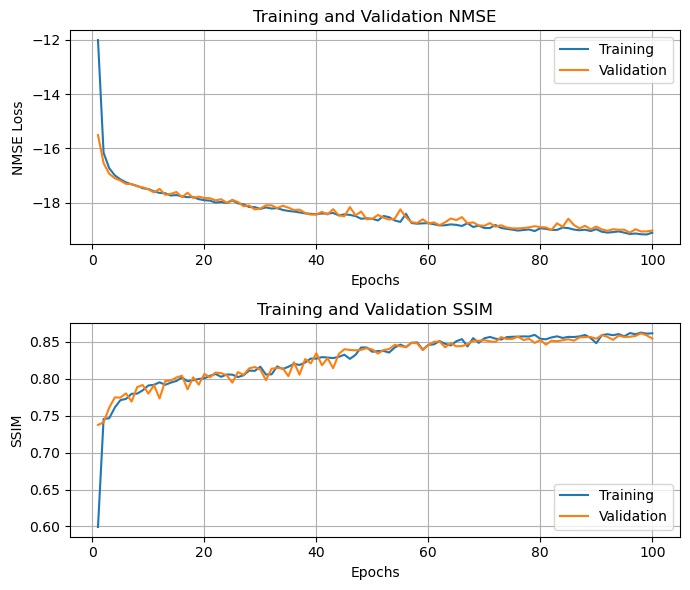

In [70]:
batch_size = 2 # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 100 # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
val_loader = create_loader(val_dataset, batch_size)

model = MihirNet3() # Pick a model
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
criterion = nn.MSELoss() # Pick a loss function

# Let's train the model
train_model(model, opt, criterion, train_loader, val_loader, num_epoch, noise_std=sig)

In [ ]:
for i, y_tr_batch in enumerate(train_loader):
    print(y_tr_batch)

In [ ]:
# save the model
model = MihirNet2() # Pick a model
sig = 0.1
PATH = 'MihirNet2_100e.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
model.parameters

In [ ]:
model.load_state_dict(torch.load(PATH))

___
### Apply it to one of the validation image

/Users/mihirjoshi/anaconda3/lib/python3.11/site-packages/torch/nn/functional.py:1391: UserWarning: dropout3d: Received a 3-D input to dropout3d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout3d exists to provide channel-wise dropout on inputs with 3 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 4D or 5D inputs).
  warnings.warn(warn_msg)


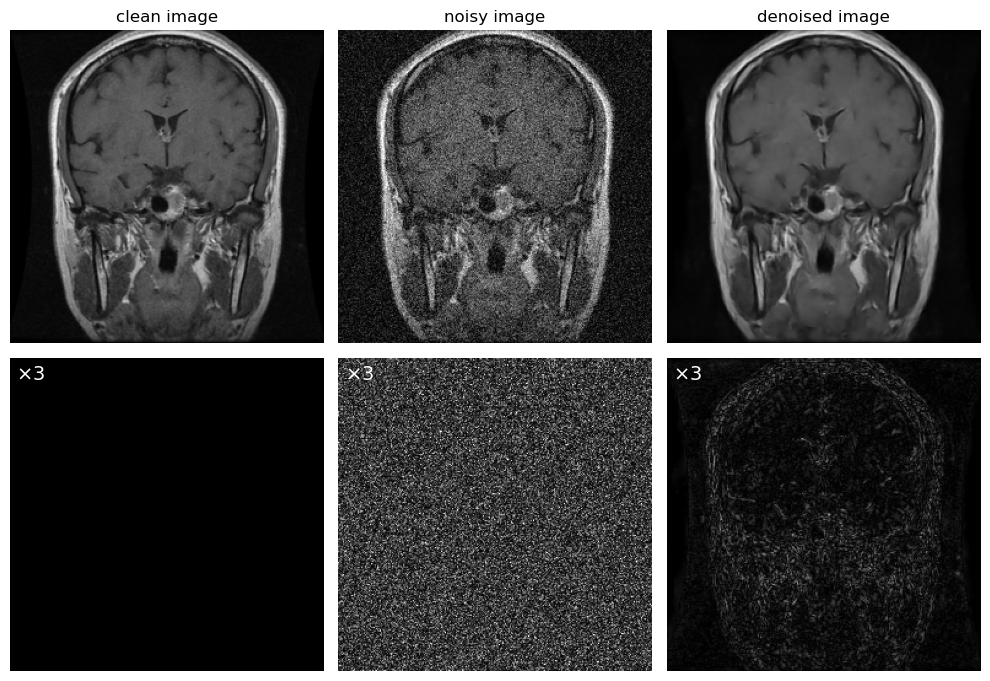

In [71]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')


plt.tight_layout()
plt.show()


# Model Evaluation

In [ ]:
# Load model

# PATH = 'MihirNet2_100e.pt'
# model = MihirNet2()
# model.load_state_dict(torch.load(PATH))
# model

### Grade Calculation

In [17]:
# Load Testing Data

test_dataset = TIFFDataset('test-clean-tif', transform=transform) # Create the dataset for testing images

In [72]:
# Grade Calculation Code

NMSE_te = 0
NMSE_te_sum = 0
SSIM_te = 0
SSIM_te_sum = 0

NMSE_va = 0
NMSE_va_sum = 0
SSIM_va = 0
SSIM_va_sum = 0

sig = 0.1

for val_clean in val_dataset:
    # add random noise
    val_noisy = val_clean + (torch.randn_like(val_clean) * sig)

    # remove noise with model
    val_denoised = model(val_noisy)

    NMSE_va_sum += calculateNMSE(val_clean, val_denoised)
    SSIM_va_sum += calculateSSIM(val_clean, val_denoised)

for test_clean in test_dataset:
    # add random noise
    test_noisy = test_clean + (torch.randn_like(test_clean) * sig)

    # remove noise with model
    test_denoised = model(test_noisy)

    NMSE_te_sum += calculateNMSE(test_clean, test_denoised)
    SSIM_te_sum += calculateSSIM(test_clean, test_denoised)


NMSE_va = NMSE_va_sum / len(val_dataset)
SSIM_va = SSIM_va_sum / len(val_dataset)

NMSE_te = NMSE_te_sum / len(test_dataset)
SSIM_te = SSIM_te_sum / len(test_dataset)

print(f"NMSE_va: {NMSE_va:0.3f}")
print(f"SSIM_va: {SSIM_va:0.3f}")
print()
print(f"NMSE_te: {NMSE_te:0.3f}")
print(f"SSIM_te: {SSIM_te:0.3f}")
print()

NMSE_ref = -20.7 # change to be max from all teams

grade = min((100 - 5*(NMSE_te - NMSE_ref), 100)) # TODO: change to testing set
print(f"Grade: {grade:0.3f}")

NMSE_va: -19.055
SSIM_va: 0.855

NMSE_te: -19.273
SSIM_te: 0.860

Grade: 92.864


### Trivial Net

##### NMSE_te: -14.651 (validation set)
##### SSIM_te: 0.594 (validation set)
##### Grade: 69.755

lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 20  # Epochs

### MihirNet1

##### NMSE_te: -18.200 (validation set)
##### SSIM_te: 0.835 (validation set)
##### Grade: 87.500

# Questions

#### Is the NMSE being calculated correctly?
#### Is the SNR too high? How can the SNR calculation be modified?

## Things to try


### add more feature extraction (like edge detection)

### adding more random noise

### dimensionality reduction of images

### dense network

### create artificial testing set (with varying noise)

### use diffusion models